# 🧠 PyTorch Neural Network Training
====================================

Step-by-step exploration of the `pytorch_network.py` implementation for robot navigation.

**What you'll learn:**
- PyTorch neural network architecture and training
- Configuration management with YAML
- Model evaluation and performance analysis


## 1. Setup and Data Loading


In [26]:
# Setup and imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Force reload modules to get latest version
import importlib
import core.pytorch_network
importlib.reload(core.pytorch_network)

# Import our custom modules
from core.pytorch_network import RobotNavigationNet, RobotNavigationTrainer, load_config, create_data_loaders
from core.data_generation import load_training_data

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Setup complete!")
print(f"🖥️  PyTorch version: {torch.__version__}")
print(f"🔧 Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

# 🎯 CONFIGURATION SELECTION
# ==========================
# Choose your perception mode: '3x3' or '5x5'
PERCEPTION_MODE = '5x5'  # Change this to '3x3' for 3×3 mode

print(f"\n🎯 SELECTED PERCEPTION MODE: {PERCEPTION_MODE}")
print("=" * 50)

# Test load_config function first
print("Testing load_config function...")
try:
    config = load_config(perception_mode=PERCEPTION_MODE)
    print(f"✅ Configuration loaded successfully for {PERCEPTION_MODE} mode")
    print(f"   Input size: {config['model']['input_size']}")
    print(f"   Perception size: {config['model']['perception_size']}")
except Exception as e:
    print(f"❌ Error loading config: {e}")
    print("Falling back to default config...")
    config = load_config()  # Try without perception_mode

# Determine data file based on perception mode
if PERCEPTION_MODE == '5x5':
    data_filename = "large_training_dataset_5x5.npz"
    expected_features = 37
else:  # 3x3
    data_filename = "large_training_dataset.npz" 
    expected_features = 21

data_path = project_root / "data" / "raw" / data_filename

try:
    X, y, metadata = load_training_data(data_path)
    print(f"\n✅ Data loaded: {X.shape[0]} samples, {X.shape[1]} features")
    
    # Verify feature count matches expectation
    if X.shape[1] == expected_features:
        print(f"✅ Feature count matches {PERCEPTION_MODE} mode expectation")
    else:
        print(f"⚠️  Warning: Expected {expected_features} features for {PERCEPTION_MODE}, got {X.shape[1]}")
    
    print(f"📊 Action distribution: {np.bincount(y)}")
    
    # Show mode-specific information
    if PERCEPTION_MODE == '5x5':
        print(f"🧠 Enhanced 5×5 Mode: {X.shape[1]} features")
        print(f"   • Perception: 25 features (5×5 grid)")
        print(f"   • History: 12 features (3 actions × 4 one-hot)")
    else:  # 3x3
        print(f"🧠 Enhanced 3×3 Mode: {X.shape[1]} features")
        print(f"   • Perception: 9 features (3×3 grid)")
        print(f"   • History: 12 features (3 actions × 4 one-hot)")
        
except FileNotFoundError:
    print(f"❌ Data file not found: {data_path}")
    print(f"💡 Run 'python scripts/generate_data.py large --perception {PERCEPTION_MODE}' first")

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X, y,
    batch_size=config['training']['batch_size'],
    train_ratio=config['data']['train_ratio'],
    val_ratio=config['data']['val_ratio'],
    test_ratio=config['data']['test_ratio']
)

print(f"\n📊 Data splits: Train={len(train_loader.dataset)}, Val={len(val_loader.dataset)}, Test={len(test_loader.dataset)}")


✅ Setup complete!
🖥️  PyTorch version: 2.8.0
🔧 Device: CPU

🎯 SELECTED PERCEPTION MODE: 5x5
Testing load_config function...
✅ Configuration loaded from /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/configs/nn_config.yaml
🎯 Updated config for 5×5 Enhanced Mode (37 features)
✅ Configuration loaded successfully for 5x5 mode
   Input size: 37
   Perception size: 25
❌ Data file not found: /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/data/raw/large_training_dataset_5x5.npz
💡 Run 'python scripts/generate_data.py large --perception 5x5' first
📊 Data splits:
   Train: 6863 samples
   Validation: 859 samples
   Test: 858 samples

📊 Data splits: Train=6863, Val=859, Test=858


In [33]:
# 🔄 CONFIGURATION COMPARISON
# =========================
# Compare 3×3 vs 5×5 configurations

print("📊 PERCEPTION MODE COMPARISON")
print("=" * 50)

configs = {}
for mode in ['3x3', '5x5']:
    configs[mode] = load_config(perception_mode=mode)
    model_config = configs[mode]['model']
    print(f"\n{mode.upper()} MODE:")
    print(f"  • Input Size: {model_config['input_size']} features")
    print(f"  • Perception Size: {model_config['perception_size']} features")
    print(f"  • History Size: {model_config['history_size']} features")
    print(f"  • Hidden Layer 1: {model_config['hidden1_size']} neurons")
    print(f"  • Hidden Layer 2: {model_config['hidden2_size']} neurons")

print(f"\n🎯 CURRENT MODE: {PERCEPTION_MODE.upper()}")
print(f"   Using config: {configs[PERCEPTION_MODE]['model']['input_size']} input features")

📊 PERCEPTION MODE COMPARISON
✅ Configuration loaded from /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/configs/nn_config.yaml
🎯 Updated config for 3×3 Enhanced Mode (21 features)

3X3 MODE:
  • Input Size: 21 features
  • Perception Size: 9 features
  • History Size: 12 features
  • Hidden Layer 1: 64 neurons
  • Hidden Layer 2: 32 neurons
✅ Configuration loaded from /Users/omkar/Documents/GitHub/AI_Projects/Robot-Navigation/configs/nn_config.yaml
🎯 Updated config for 5×5 Enhanced Mode (37 features)

5X5 MODE:
  • Input Size: 37 features
  • Perception Size: 25 features
  • History Size: 12 features
  • Hidden Layer 1: 64 neurons
  • Hidden Layer 2: 32 neurons

🎯 CURRENT MODE: 5X5
   Using config: 37 input features


In [ ]:
# 🚀 COMPLETE TRAINING AND ANALYSIS
# ===================================
print(f"🚀 TRAINING NEURAL NETWORK - {PERCEPTION_MODE.upper()} MODE")
print("=" * 60)

# Create model with current configuration
model = RobotNavigationNet(
    input_size=config['model']['input_size'],
    hidden_sizes=[config['model']['hidden1_size'], config['model']['hidden2_size']],
    dropout_rate=config['model']['dropout_rate']
)

# Create trainer
trainer = RobotNavigationTrainer(
    model=model,
    learning_rate=config['training']['learning_rate'],
    weight_decay=config['training']['weight_decay'],
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print(f"✅ Model created with {config['model']['input_size']} input features")
print(f"✅ Trainer configured with LR={config['training']['learning_rate']}")

# Show model architecture
print(f"\n🏗️ Model Architecture:")
print(f"  Input Layer:  {config['model']['input_size']} features")
print(f"  Hidden Layer 1: {config['model']['hidden1_size']} neurons")
print(f"  Hidden Layer 2: {config['model']['hidden2_size']} neurons") 
print(f"  Output Layer:  4 actions")
print(f"  Total Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train the model
print(f"\n🔥 Starting training...")
history = trainer.train(
    train_loader, 
    val_loader=val_loader,
    epochs=config['training']['epochs'],
    verbose=True
)

print(f"\n✅ Training completed!")

In [ ]:
# 📊 TRAINING RESULTS VISUALIZATION
# ==================================
print("📊 TRAINING RESULTS ANALYSIS")
print("=" * 50)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Loss plot
axes[0].plot(history['train_losses'], label='Training Loss', color='blue', linewidth=2)
axes[0].plot(history['val_losses'], label='Validation Loss', color='red', linewidth=2)
axes[0].set_title(f'Training and Validation Loss - {PERCEPTION_MODE.upper()} Mode')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_accuracies'], label='Training Accuracy', color='blue', linewidth=2)
axes[1].plot(history['val_accuracies'], label='Validation Accuracy', color='red', linewidth=2)
axes[1].set_title(f'Training and Validation Accuracy - {PERCEPTION_MODE.upper()} Mode')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze results
final_train_acc = history['train_accuracies'][-1]
final_val_acc = history['val_accuracies'][-1]
overfitting = final_train_acc - final_val_acc

print(f"\n🔍 Training Analysis:")
print(f"   Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
print(f"   Overfitting: {overfitting:.4f} ({overfitting*100:.1f}%)")

if overfitting > 0.1:
    print(f"⚠️  Warning: Significant overfitting detected!")
elif overfitting < -0.05:
    print(f"✅ Good: Model is not overfitting")
else:
    print(f"✅ Acceptable: Minimal overfitting")

# Show best epoch
best_epoch = history['val_accuracies'].index(max(history['val_accuracies']))
print(f"\n🏆 Best Performance:")
print(f"   Best Epoch: {best_epoch + 1}")
print(f"   Best Validation Accuracy: {max(history['val_accuracies']):.4f} ({max(history['val_accuracies'])*100:.1f}%)")

In [ ]:
# 🎯 MODEL EVALUATION
# ===================
print("🎯 MODEL EVALUATION ON TEST SET")
print("=" * 50)

# Evaluate on test set
test_accuracy = trainer.evaluate(test_loader)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")

# Get predictions for confusion matrix
predictions = []
true_labels = []

model.eval()
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(trainer.device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(batch_y.numpy())

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=action_names, yticklabels=action_names)
plt.title(f'Confusion Matrix - {PERCEPTION_MODE.upper()} Mode')
plt.xlabel('Predicted Action')
plt.ylabel('Actual Action')
plt.show()

# Classification Report
print(f"\n📋 Classification Report:")
print(classification_report(true_labels, predictions, target_names=action_names))

# Action-wise accuracy
action_accuracies = []
for i, action in enumerate(action_names):
    action_acc = cm[i, i] / cm[i, :].sum()
    action_accuracies.append(action_acc)
    print(f"  {action}: {action_acc:.3f} ({action_acc*100:.1f}%)")

print(f"\n📊 Action Accuracy Summary:")
print(f"  Mean Action Accuracy: {np.mean(action_accuracies):.3f} ({np.mean(action_accuracies)*100:.1f}%)")
print(f"  Std Action Accuracy: {np.std(action_accuracies):.3f} ({np.std(action_accuracies)*100:.1f}%)")

## 2. Model Architecture


In [30]:
# Create model
model = RobotNavigationNet(
    input_size=config['model']['input_size'],
    hidden1_size=config['model']['hidden1_size'],
    hidden2_size=config['model']['hidden2_size'],
    output_size=config['model']['output_size'],
    dropout_rate=config['model']['dropout_rate']
)

# Get architecture info
info = model.get_architecture_info()
print("🧠 Neural Network Architecture:")
print(f"   Architecture: {info['architecture']}")
print(f"   Total parameters: {info['total_parameters']:,}")
print(f"   Trainable parameters: {info['trainable_parameters']:,}")
print(f"   Dropout rate: {info['dropout_rate']}")

# Show model structure
print("\n🔍 Model Structure:")
print(model)


🧠 Neural Network Architecture:
   Architecture: 37 → 64 → 32 → 4
   Total parameters: 4,644
   Trainable parameters: 4,644
   Dropout rate: 0.2

🔍 Model Structure:
RobotNavigationNet(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)


## 3. Training


In [31]:
# Create trainer
trainer = RobotNavigationTrainer(
    model=model,
    learning_rate=config['training']['learning_rate']
)

print("✅ Model and trainer created!")
print(f"📊 Training configuration:")
print(f"   Learning rate: {config['training']['learning_rate']}")
print(f"   Batch size: {config['training']['batch_size']}")
print(f"   Max epochs: {config['training']['epochs']}")
print(f"   Early stopping patience: {config['training']['early_stopping']['patience']}")

# Train the model
print(f"\n🏋️ Starting training...")
history = trainer.train(
    train_loader, val_loader,
    epochs=config['training']['epochs'],
    early_stopping_patience=config['training']['early_stopping']['patience']
)

print(f"\n✅ Training completed!")
print(f"📊 Final results:")
print(f"   Best validation accuracy: {max(history['val_accuracies']):.4f}")
print(f"   Best validation loss: {min(history['val_losses']):.4f}")
print(f"   Training epochs: {len(history['train_losses'])}")


✅ Model and trainer created!
📊 Training configuration:
   Learning rate: 0.0005
   Batch size: 64
   Max epochs: 200
   Early stopping patience: 55

🏋️ Starting training...
🚀 Starting training on cpu
🧠 Architecture: 37 → 64 → 32 → 4
⚙️  Learning rate: 0.0005
🛡️  Dropout rate: 0.2
------------------------------------------------------------
Epoch   0: Train Loss=1.3623, Train Acc=33.28%, Val Loss=1.3055, Val Acc=49.83%
Epoch  10: Train Loss=0.9985, Train Acc=74.60%, Val Loss=0.9741, Val Acc=76.60%
Epoch  20: Train Loss=0.9685, Train Acc=77.39%, Val Loss=0.9595, Val Acc=77.30%
Epoch  30: Train Loss=0.9566, Train Acc=78.77%, Val Loss=0.9558, Val Acc=77.53%
Epoch  40: Train Loss=0.9458, Train Acc=79.72%, Val Loss=0.9499, Val Acc=79.28%
Epoch  50: Train Loss=0.9333, Train Acc=81.09%, Val Loss=0.9490, Val Acc=79.16%
Epoch  60: Train Loss=0.9309, Train Acc=81.17%, Val Loss=0.9467, Val Acc=78.81%
Epoch  70: Train Loss=0.9282, Train Acc=81.42%, Val Loss=0.9519, Val Acc=78.46%
Epoch  80: Train L

## 4. Training Visualization


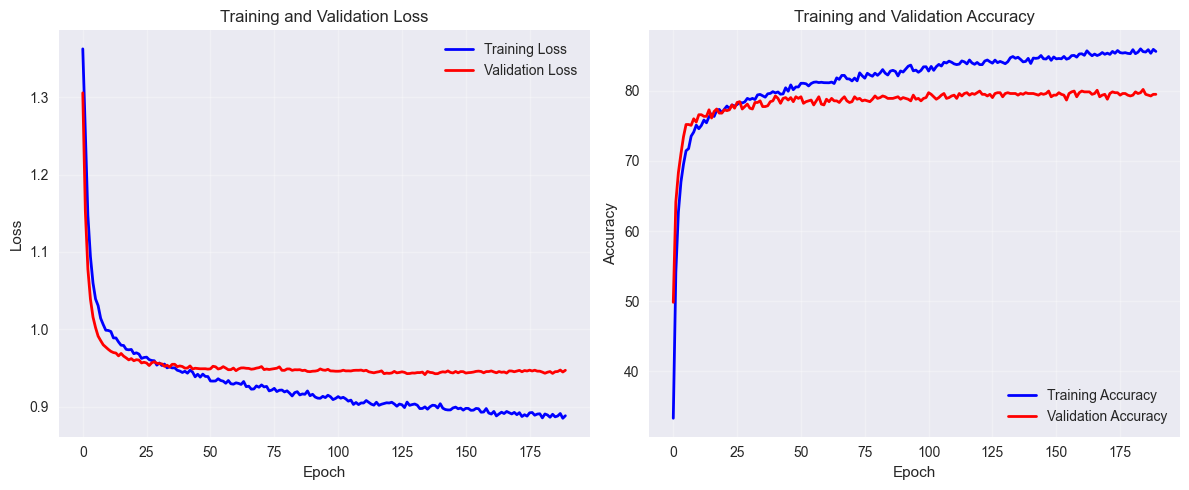


🔍 Training Analysis:
   Training Accuracy: 85.6331 (8563.3%)
   Validation Accuracy: 79.5111 (7951.1%)
   Overfitting: 6.1220 (612.2%)
⚠️  Warning: Significant overfitting detected!


In [32]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss plot
axes[0].plot(history['train_losses'], label='Training Loss', color='blue', linewidth=2)
axes[0].plot(history['val_losses'], label='Validation Loss', color='red', linewidth=2)
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_accuracies'], label='Training Accuracy', color='blue', linewidth=2)
axes[1].plot(history['val_accuracies'], label='Validation Accuracy', color='red', linewidth=2)
axes[1].set_title('Training and Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze results
final_train_acc = history['train_accuracies'][-1]
final_val_acc = history['val_accuracies'][-1]
overfitting = final_train_acc - final_val_acc

print(f"\n🔍 Training Analysis:")
print(f"   Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
print(f"   Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.1f}%)")
print(f"   Overfitting: {overfitting:.4f} ({overfitting*100:.1f}%)")

if overfitting > 0.1:
    print(f"⚠️  Warning: Significant overfitting detected!")
elif overfitting < -0.05:
    print(f"✅ Good: Model is not overfitting")
else:
    print(f"✅ Acceptable: Minimal overfitting")


## 5. Model Evaluation


📊 Test Set Performance:
   Test Accuracy: 0.9257 (92.6%)
   Test Loss: 81.8182


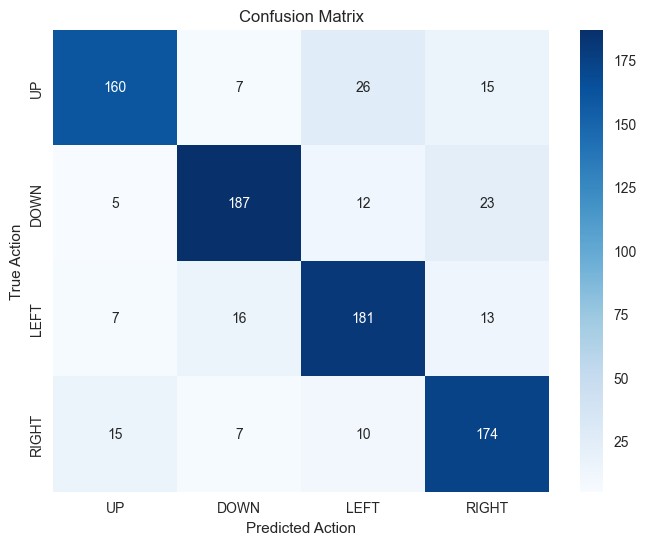


📋 Classification Report:
              precision    recall  f1-score   support

          UP       0.86      0.77      0.81       208
        DOWN       0.86      0.82      0.84       227
        LEFT       0.79      0.83      0.81       217
       RIGHT       0.77      0.84      0.81       206

    accuracy                           0.82       858
   macro avg       0.82      0.82      0.82       858
weighted avg       0.82      0.82      0.82       858



In [34]:
# Evaluate on test set
test_accuracy, test_loss = trainer.evaluate(test_loader)
print(f"📊 Test Set Performance:")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"   Test Loss: {test_loss:.4f}")

# Get predictions for confusion matrix
model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Create confusion matrix
action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
cm = confusion_matrix(all_targets, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=action_names, yticklabels=action_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Action')
plt.ylabel('True Action')
plt.show()

# Print classification report
print(f"\n📋 Classification Report:")
print(classification_report(all_targets, all_predictions, target_names=action_names))


## 7. Architecture Design Choices Explained

**Why 2 Hidden Layers with 64 → 32 neurons?**


In [ ]:
print("\n2️⃣ NEURAL NETWORK ARCHITECTURE EXPLANATION")
print("-" * 50)

# Dynamic architecture explanation based on perception mode
if PERCEPTION_MODE == '5x5':
    perception_size = 25
    perception_desc = "5×5"
    total_features = 37
else:  # 3x3
    perception_size = 9
    perception_desc = "3×3"
    total_features = 21

print(f"• Input: {total_features} features ({perception_desc} perception + action history)")
print(f"• Hidden1: 64 neurons ({64/total_features:.1f}× expansion for pattern extraction)")
print(f"• Hidden2: 32 neurons ({32/total_features:.1f}× compression for decision making)")
print(f"• Output: 4 neurons (one per action: UP, DOWN, LEFT, RIGHT)")

print("\n🧠 BIOLOGICAL INSPIRATION:")
print("-" * 30)
print("• Visual Cortex: Processes {perception_desc} visual input".format(perception_desc=perception_desc))
print("• Association Cortex: Combines visual + memory information")
print("• Motor Cortex: Fewer neurons make final decisions")
print("• Our network mimics this hierarchy:")
print(f"  - Layer 1: Extract patterns from {perception_desc} perception + history")
print(f"  - Layer 2: Combine patterns into navigation decisions")
print(f"  - Output: Choose optimal action from 4 possibilities")


## 6. Summary

**What you've learned:**
- ✅ PyTorch neural network architecture (9→64→32→4)
- ✅ Configuration management with YAML
- ✅ Training process with early stopping
- ✅ Performance evaluation and visualization

**Key insights:**
- ReLU activation prevents vanishing gradients
- Dropout helps prevent overfitting
- Early stopping saves training time
- Confusion matrix shows prediction patterns
